# Primary Grid to Dualgrid Conversion

## To Do:
- Primary grid must be stored as tuple list 
- Only pointers in dualgrid functions!


## Interior Dualgrid:
Each dualgrid cell is stored as list array. Dualcell loop starts always with adjacent primary element with lowest x- and y-values.
The loop moves from this element centroid to the centroid of an adjacent edge to the next element centroid and so on.
If a node has $N$ adjacent elements, there will be $N$ element centroids and $N$ edge centroids  in the dualcell list. So the loop ends, if len(duallist) equals $2N$.

    1) Start at interior node $i$

    2) Move to adjacent element with lowest x- and y-values and append element to dualcell list.

    3) Grab the edges of this element, that are adjacent to node $i$ and add the edge, that is not yet in the current dualcell list. If none of these edges is already part of the current dualcell list, append the one with the lowest x- and y-centroid.

    4) Move to the adjacent element of this edge.

In [4]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np




def get_edge_to_triangle_connection(T):
    '''
    Function to determine the neighbouring elements of an edge in a triangular mesh
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        edges: dictionary - keys are two node indices, that define a triangles edge
               every key has a list of two values, which are the adjacent triangles 
               to the edge. If the last value is -1, the edge is located at the boundary
               
    '''
    E2T = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all current edges
        for iE in range(3):
            edge = (tri[iE], tri[(iE+1)%3])
            
            # Check if edge is already in dictionary
            if (edge in E2T) or (edge[::-1] in E2T):
                try:
                    E2T[edge][1] = tuple(tri)#iTri
                except:
                    E2T[edge[::-1]][1] = tuple(tri) #iTri
            else:
                E2T.update({edge:[tuple(tri), -1]})
    return E2T
            
    
def get_node_to_triangle_connection(T):
    '''
    Function to determine the triangles, that are adjacent to a node in the triangular mesh.
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent triangular elements

    '''
    nodes = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all triangle nodes
        for n in tri:
            if n in nodes:
                nodes[n].append(tuple(tri))
            else:
                nodes.update({n: [tuple(tri)]})
    return nodes
            
            
def get_node_to_edge_connection(E2T):
    '''
    Function determines which edges are adjacent to the mesh nodes
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent mesh-edges
    
    '''
    nodes = {}
    # Loop over all edges
    for edg in E2T:
        # Loop over all nodes of the respective edge
        for n in edg:
            if n in nodes:
                nodes[n].append(edg)
            else:
                nodes.update({n: [edg]})
    return nodes


def get_triangle_to_triangle_connection(E2T):
    '''
    This function creates the connectivity between triangular elements
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: T2T - dictionary - keys are the triangles in node connectivity format
            and values are a list with three entries, that have the neighbouring
            triangle node connectivities or -1 if that edge is at the boundary
    '''
    T2T = {}
    for edg in E2T:
        # Get the triangles that are already found, in "set()" format
        keys = [set(k) for k in T2T.keys()]
        # Check both adjacent triangles to current face 
        for itri, tri in enumerate(E2T[edg]):
            # Boundary edges will have set -1 as second triangle
            if (tri == -1):
                continue   
            # check if triangle exists - if not, add triangle to T2T
            if set(tri) not in keys:
                T2T.update({tri: [-1, -1, -1]})    
            # Check, which indice "edg" has in the current triangle
            # This triangle will then get the neighbor triangle at the
            # same position in the T2T-list
            indEdg = 0
            for iE in range(3):
                edgTri = set((tri[iE], tri[(iE+1)%3]))
                if (set(edg) == edgTri):
                    T2T[tri][indEdg] = E2T[edg][(itri+1)%2]
                indEdg += 1  
    return T2T
        

def get_boundary_nodes(E2T):
    '''
    This function determines, which nodes are located at the boundary
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: list of node indices, that are adjacent to a boundary
    '''
    nodes = []
    for edg in E2T:
        if E2T[edg][1] == -1:
            nodes.append(edg[0])
    return nodes


def get_interior_nodes(bdry_nodes, N):
    '''
    This function determines, which nodes are located in the interior of the domain
    
    Input: bdry_nodes - list with indices of nodes that are adjacent to a boundary
           N - length of global node array
    
    Output: list of node indices, that are not adjacent to a boundary
    '''
    nodes = []
    for i in range(N):
        if i not in bdry_nodes:
            nodes.append(i)
    return nodes


def eval_edge_centroid(x, y, edge):
    '''
    This function computes the centroid of an edge (i0,i1)
    '''
    xc, yc = 0.0, 0.0
    for i in range(2):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/2.0, yc/2.0))

def eval_triangle_centroid(x, y, triangle):
    '''
    This function computes the centroid of a triangle (i0,i1,i2)
    '''
    xc, yc = 0.0, 0.0
    for i in range(3):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/3.0, yc/3.0))
    

def get_interior_dual_median_cell(iNode, x, y, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity list around an interior node "iNode"
    The connectivity list is of the following type:
    [(v0,v1,v2), (v0,v1), (v0,v1,v2),(v0,v1),...]
      \      /    \   /
        node       node
      indices      indices
      of element   of edge
    '''
    
    adjEdge      = N2E[iNode] # all edges that are adjacent to this node
    adjTri       = N2T[iNode] # all triangles that are adjacent to this node
    adjEdge_keys = [set(edg) for edg in adjEdge] # set array of adjacent edges
    N            = len(adjTri) # Number of adjacent elements
    
    dualcell     = [adjTri[0]] # The dualcell-list - start with first triangle in "adTri" 
    dualkeys     = [set(dc) for dc in dualcell] # array of keys with already appended elements / edges
    
    maxIter = 0 # Iteration counter  
    while (len(dualcell) < 2*N) and (maxIter < 3*N):
        maxIter += 1
        # Loop over all edges of the last element in dualcell-list
        for iEdge in range(3):
            edge = set(( dualcell[-1][iEdge], dualcell[-1][(iEdge+1)%3] ))
            # Check if this edge is part of the adjacend edges to node 
            # and if this edge has already been appended to dualcell list
            if (edge not in dualkeys) and (edge in adjEdge_keys):
                # Find current edge in "adjEdge" list
                for adEdge in adjEdge:
                    if (edge == set(adEdge)):
                        # Find adjacent triangle to this edge, that is not the
                        # current triangle
                        if (set(dualcell[-1]) == set(E2T[adEdge][0])):
                            nextElem = E2T[adEdge][1]
                        else:
                            nextElem = E2T[adEdge][0]
                        dualcell.append(adEdge)
                        # Add new keys
                        dualkeys.append(set(dualcell[-1]))
                        if (len(dualcell)<2*N):
                            dualcell.append(nextElem)
                            # Add new keys
                            dualkeys.append(set(dualcell[-1]))
                        continue
                        
                if (len(dualcell)>= 2*N):
                    break
    return dualcell  
    
    
def get_boundary_dual_median_cell(iNode, x, y, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity list around an boundary node "iNode"
    The connectivity list is of the following type:
    [(v0),(v0,v1),(v0,v1,v2), (v0,v1), (v0,v1,v2),(v0,v1),...]
      \ /  \   /    \    /
  boundary  node     node
     node   indices  indices
            of edge  of element
    '''
    adjEdge      = N2E[iNode] # all edges that are adjacent to this node
    adjTri       = N2T[iNode] # all triangles that are adjacent to this node
    adjEdge_keys = [set(edg) for edg in adjEdge] # set array of adjacent edges
    N            = len(adjTri) # Number of adjacent elements
    
    dualcell     = [] # The dualcell-list
    # Add this node to the dualcell
    dualcell.append(tuple([iNode]))
    # Start with first edge in "adjEdge", which is a boundary edge
    for adEdge in adjEdge:
        if E2T[adEdge][1] == -1:
            dualcell.append(adEdge)
            break
    # Add adjacent element to this boundary edge
    dualcell.append(E2T[dualcell[-1]][0])
    dualkeys     = [set(dc) for dc in dualcell] # array of keys with already appended elements / edges
    
    maxIter = 0 # Iteration counter  
    while (len(dualcell) < 2*N+2) and (maxIter < 3*N):
        maxIter += 1
        # Loop over all edges of the last element in dualcell-list
        for iEdge in range(3):
            edge = set(( dualcell[-1][iEdge], dualcell[-1][(iEdge+1)%3] ))
            # Check if this edge is part of the adjacend edges to node 
            # and if this edge has already been appended to dualcell list
            if (edge not in dualkeys) and (edge in adjEdge_keys):
                # Find current edge in "adjEdge" list
                for adEdge in adjEdge:
                    if (edge == set(adEdge)):
                        # Find adjacent triangle to this edge, that is not the
                        # current triangle
                        if (set(dualcell[-1]) == set(E2T[adEdge][0])):
                            nextElem = E2T[adEdge][1]
                        else:
                            nextElem = E2T[adEdge][0]
                        dualcell.append(adEdge)
                        # Add new keys
                        dualkeys.append(set(dualcell[-1]))
                        if (len(dualcell)<2*N+1):
                            dualcell.append(nextElem)
                            # Add new keys
                            dualkeys.append(set(dualcell[-1]))
                        continue
                        
                if (len(dualcell)>= 2*N+2):
                    break
                    
    return dualcell


def get_triangle_id_list(T):
    '''
    This function sets up a dictionary for a given triangulation T, whereas the triangle
    node connectivity is key and its element-index in the primary mesh is value
    '''
    T_ID = {}
    for iTri, tri in enumerate(T):
        T_ID.update({T[iTri] : iTri})
    return T_ID

def get_edge_id_list(E2T):
    '''
    This function sets up a dictionary for a given edge-to-triangle list E2T, whereas the edge to
    node connectivity is key and its edge-index in the E2T list is value
    '''
    E_ID = {}
    for iEdg, edg in enumerate(E2T):
        E_ID.update({edg : iEdg})
    return E_ID

def get_bdry_node_id_list(bdry_nodes):
    '''
    This function sets up a dictionary for a given boundary node list, whereas the edge to
    node connectivity is key and its edge-index in the E2T list is value
    '''
    BN_ID = {}
    for iNode, node in enumerate(bdry_nodes):
        BN_ID.update({node : iNode})
    return BN_ID


def compute_element_centroid(x,y,element):
    '''
    This function computes the geometrical centroid of an 2D geometric object
    '''
    N_vert = len(element)
    xc, yc = 0.0, 0.0
    for i in range(N_vert):
        xc += x[element[i]]
        yc += y[element[i]]
        
    return (xc/N_vert, yc/N_vert)
        
    
def create_dual_vertices(x, y, T_ID, E_ID, bdry_nodes):
    '''
    This function creates a new x and y array vertices,
    which are used to define the median-dual mesh.
    The vertices are arranged in the following way:
    First all triangle centroids are stored, then all edge 
    centroids and finally all boundary nodes.
    '''
    x_dual, y_dual = [], []
    for tri in T_ID:
        (xc,yc) = compute_element_centroid(x,y,tri)
        x_dual.append(xc)
        y_dual.append(yc)

    for edg in E_ID:
        (xc,yc) = compute_element_centroid(x,y,edg)
        x_dual.append(xc)
        y_dual.append(yc)

    for bNd in bdry_nodes:
        x_dual.append(x[bNd])
        y_dual.append(y[bNd])
    
    return (x_dual, y_dual)


def create_interior_dual_adjacency_list(x, y, T_ID, E_ID, N2T, N2E, E2T, intr_nodes):
    '''
    This function creates the adjacency list for the interior elements of the
    median-dual mesh
    '''
    # Create dualmesh adjacency list for interor elements
    intr_cells =[]
    N_T_ID = len(T_ID)
    N_E_ID = len(E_ID)

    for iNode in intr_nodes:
        # determine current cell adjacency list in primary grid indices format
        intr_cell = get_interior_dual_median_cell(iNode, x, y, N2T, N2E, E2T)
        # Convert to dualmesh indices format
        intr_cell_dual = []
        for iCell in intr_cell:
            if (len(iCell) == 3): 
                intr_cell_dual.append(T_ID[iCell])
            if (len(iCell) == 2):
                intr_cell_dual.append(E_ID[iCell] + N_T_ID)
        intr_cells.append(intr_cell_dual)
        
    return intr_cells


def create_boundary_dual_adjacency_list(x, y, T_ID, E_ID, BN_ID, N2T, N2E, E2T, bdry_nodes):
    '''
    This function creates the adjacency list for the boundary elements of the
    median-dual mesh
    '''
    # Create dualmesh adjacency list for boundary elements
    bdry_cells = []
    N_T_ID = len(T_ID)
    N_E_ID = len(E_ID)
    for iNode in bdry_nodes:
        # determine current cell adjacency list in primary grid indices format
        bdry_cell = get_boundary_dual_median_cell(iNode, x, y, N2T, N2E, E2T)
        # Convert to dualmesh indices format
        bdry_cell_dual = []
        for iCell in bdry_cell:
            if (len(iCell) == 3): 
                bdry_cell_dual.append(T_ID[iCell])
            if (len(iCell) == 2):
                bdry_cell_dual.append(E_ID[iCell] + N_T_ID)
            if (len(iCell) == 1):
                bdry_cell_dual.append(BN_ID[iCell[0]] + N_T_ID + N_E_ID)
        bdry_cells.append(bdry_cell_dual)
    
    return bdry_cells



class TriDual:
    '''
    This class computes the median-dual of a matplotlib triangulation object T
    '''
    def __init__(self, x, y, T):
        # Store vertex coordinates
        self.x, self.y = x, y
        self.Nvertices = len(x)
        
        # Initialize field variables
        self.fieldVars = {}
        
        # Convert triangulation T to python list object
        self.T = [tuple(tri) for tri in T.triangles]

        # Compute adjacency lists 
        self.E2T = get_edge_to_triangle_connection(self.T)
        self.N2T = get_node_to_triangle_connection(self.T)
        self.N2E = get_node_to_edge_connection(self.E2T)
        self.T2T = get_triangle_to_triangle_connection(self.E2T)
        self.bdry_nodes = get_boundary_nodes(self.E2T)
        self.intr_nodes = get_interior_nodes(self.bdry_nodes, self.Nvertices)

        # Create new global dualmesh vertex array 
        # -> First all element centroids
        # -> Then all edge centroids
        # -> Then all boundary nodes
        self.T_ID = get_triangle_id_list(self.T)
        self.E_ID = get_edge_id_list(self.E2T)
        self.BN_ID = get_bdry_node_id_list(self.bdry_nodes)
        
        # Create dualmesh vertex list
        (self.x_dual, self.y_dual) = create_dual_vertices(self.x, self.y, self.T_ID, self.E_ID, self.bdry_nodes)
        
        # Create dualmesh adjacency lists
        self.intr_cells = create_interior_dual_adjacency_list(self.x, self.y, self.T_ID, self.E_ID, self.N2T, self.N2E, self.E2T, self.intr_nodes)
        self.bdry_cells = create_boundary_dual_adjacency_list(self.x, self.y, self.T_ID, self.E_ID, self.BN_ID, self.N2T, self.N2E, self.E2T, self.bdry_nodes)

    def add_field_variable(self, varName):
        '''
        This function initialize an array which can be used to store a field variable
        '''
        self.fieldVars.update({varName: [0.0]*self.Nvertices})
        
    def plot_primary_grid(self, ax, **kwargs):
        '''
        This method plots the primary triangulation on a given matplotlib axis object
        '''
        plotVertices = kwargs.get('plotVertices', False)
        fieldVarName = kwargs.get('fieldVar', None)
        
        tri_patches = []
        for tri in self.T:
            poly = Polygon([[self.x[iNode], self.y[iNode]] for iNode in tri])
            tri_patches.append(poly)

        if plotVertices:
            for i in range(self.Nvertices):
                ax.plot(self.x[i], self.y[i], marker='o', mfc='k',mec='None')
                ax.text(self.x[i], self.y[i], str(i))

        tri_patchCol = PatchCollection(tri_patches, edgecolor='k')
        ax.add_collection(tri_patchCol)
                

    
    def plot_dual_grid(self, ax, **kwargs):
        '''
        This method plots the dual triangulation on a given matplotlib axis object
        '''
        plotVertices = kwargs.get('plotVertices', False)
        fieldVarName = kwargs.get('fieldVar', None)
        
        dual_patches = [None] * self.Nvertices
        for iCell, dualcell in enumerate(self.intr_cells):
            poly = Polygon([[self.x_dual[iNode], self.y_dual[iNode]] for iNode in dualcell])
            dual_patches[self.intr_nodes[iCell]] = poly
            
        for iCell, dualcell in enumerate(self.bdry_cells):
            poly = Polygon([[self.x_dual[iNode], self.y_dual[iNode]] for iNode in dualcell])
            dual_patches[self.bdry_nodes[iCell]] = poly
            
        if plotVertices:
            for i in range(self.Nvertices):
                ax.plot(self.x[i], self.y[i], marker='o', mfc='k',mec='None')
                ax.text(self.x[i], self.y[i], str(i))

        if (fieldVarName != None):
            fieldVar = self.fieldVars[fieldVarName]
            # Create colormap
            cmap = plt.get_cmap('jet')
            levels = MaxNLocator(nbins=25).tick_values(min(fieldVar), max(fieldVar))
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
            
        
        dual_patchCol = PatchCollection(dual_patches,
                                        cmap=cmap, norm=norm,
                                        edgecolor='k')
        ax.add_collection(dual_patchCol)
        
        if (fieldVarName != None):
            dual_patchCol.set_array(np.array(fieldVar))
            plt.colorbar(dual_patchCol,orientation='vertical')

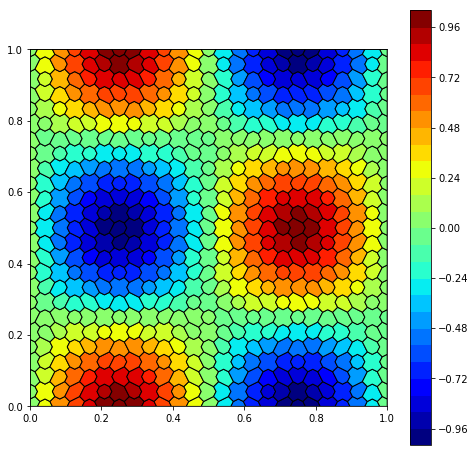

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from numpy import pi, sin, cos

def foo(x, y):
    return sin(2.*pi*x) * cos(2.*pi*y)



x0 = (0, 1)
y0 = (0, 1)

Nx, Ny = 25, 25
hx = (x0[1] - x0[0]) / (Nx-1)
hy = (y0[1] - y0[0]) / (Ny-1)

x = [x0[0] + i*hx for j in range(Ny) for i in range(Nx)]
y = [y0[0] + j*hy for j in range(Ny) for i in range(Nx)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
D = TriDual(x, y, T)


# Compute field variable
#------------------------------------------------------
D.add_field_variable('phi')
for i in D.intr_nodes + D.bdry_nodes:
    D.fieldVars['phi'][i] = foo(D.x[i], D.y[i])
    

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
#D.plot_primary_grid(ax, fieldVar='phi')

D.plot_dual_grid(ax, fieldVar='phi')
ax.set_xlim(x0)
ax.set_ylim(y0)

plt.show()



# Least Squares Methods

For reference see:
- "An As-Short-As-Possible Introduction to the Least-Squares, Weighted Least Squares and Moving Least Squares Methods for Scattered Data Approximation and Interpolation" by Andrew Nealen

## Introduction
Assume $N$ points at locations $\mathbf{x}_i$ in $R^d$ where $i \in [1,...,N]$.

We want to find a globally defined function $f(\mathbf{x})$, which approximates some given values $f_i$ at positions $\mathbf{x}_i$. 
Therefore, we define the error functional 
$$
J_{LS} = \sum_{i} || f(\mathbf{x}_i) - f_i || ^2 
$$
an the problem definition is to find $f$, such that it minimizes this error functional

$$
\text{min}\, (J_{LS}), \quad \text{for} \,f \in \Pi_m^d.
$$

Hereby $f$ is taken from $\Pi_m^d$, which denotes the space of polynomials of total degree $m$ in $d$ spatial dimensions.
The function $f(\mathbf{x})$ can also be written as:

$$
f(\mathbf{x}) = \mathbf{b}(\mathbf{x})^{T} \mathbf{c} =  \mathbf{b}(\mathbf{x}) \cdot \mathbf{c}
$$